In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp
import scipy.linalg

from generate_data import *
from compute_risk import *
from plot import *
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import itertools
sns.set(font_scale=1.2, style = "white")

# Ex1 

## Ridgeless and lassoless in $p$ (Figure 1)

In [151]:
def scatter(axes, idx, _df, **kwargs):
    axes[0].scatter(_df.loc[idx, 'p'], _df.loc[idx, 'err_R'], **kwargs)
    axes[1].scatter(_df.loc[idx, 'p'], _df.loc[idx, 'dof_R'], **kwargs)
    axes[2].scatter(_df.loc[idx, 'dof_R'], _df.loc[idx, 'err_R'], **kwargs)
    return axes

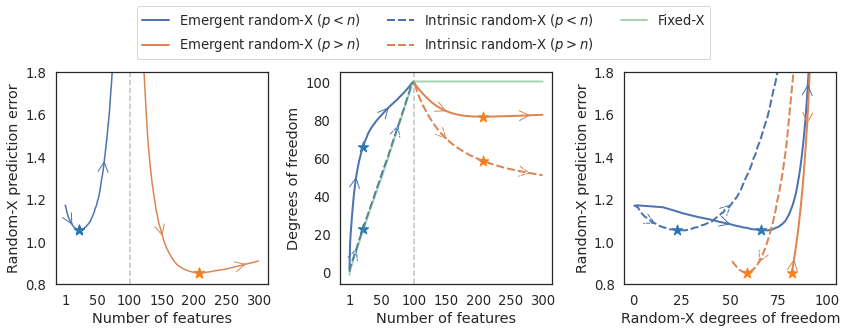

In [42]:
path_result = 'result/ex1/'
lam = 0.
method = 'partial_ridge'
predictor = 'mn2ls'

n=100; d=300; sigma = 0.4; func='quad'; coef = 'sorted'
sigma2 = sigma**2
df_res = pd.read_csv('{}res_emp_{}_{}_{}_{}_{}_{:.02f}.csv'.format(
        path_result, method, n, d, func, coef, sigma))


df_res = df_res.groupby(['n','d','sigma','type','method','lam','p']).mean()
df_res = df_res.reset_index()
df_res['dof_F'] = (df_res['err_F'] - df_res['err_T']) / (2*sigma2) * n
df_res['dof_R'] = comp_dof(df_res['err_R'], df_res['err_T'], sigma2) * n
df_res.loc[df_res['type']!='emergent','err_R'] = df_res[df_res['type']=='emergent']['err_R'].values


fig, axes = plt.subplots(1,3,figsize=(12,4.5))

sns.lineplot(data=df_res[(df_res['type']!='intrinsic')&(df_res['p']<df_res['n'])], x='p', y='err_R', ax=axes[0])
sns.lineplot(data=df_res[(df_res['type']!='intrinsic')&(df_res['p']>df_res['n'])], x='p', y='err_R', ax=axes[0])


for i,j in itertools.product(range(2),range(2)):
    _df = df_res[((df_res['type']!='intrinsic') if j==0 else (df_res['type']=='intrinsic')) & 
                 ((df_res['p']<df_res['n']) if i==0 else (df_res['p']>df_res['n']))].reset_index()
    idx = _df['err_R'].idxmin()
    scatter(axes, idx, _df, marker='*', s=120, color=sns.color_palette("tab10")[i])

sns.lineplot(data=df_res[(df_res['p']<df_res['n'])], x='p', y='dof_R', style='type', lw=2, ax=axes[1], legend='full')
sns.lineplot(data=df_res[(df_res['p']>df_res['n'])], x='p', y='dof_R', style='type', lw=2, ax=axes[1], legend='full')

sns.lineplot(data=df_res[(df_res['type']!='intrinsic')], x='p', y='dof_F', ax=axes[1], linestyle='-', lw=2, alpha=0.5, label='Fix-X DoF')

sns.lineplot(data=df_res[(df_res['p']<df_res['n'])], x='dof_R', y='err_R', style='type', lw=2, ax=axes[2])
sns.lineplot(data=df_res[(df_res['p']>df_res['n'])], x='dof_R', y='err_R', style='type', lw=2, ax=axes[2])


add_arrow(axes[0].get_lines()[0], 10, size=25)
add_arrow(axes[0].get_lines()[0], 60, size=25)
add_arrow(axes[0].get_lines()[1], 150, size=25)
add_arrow(axes[0].get_lines()[1], 280, size=25)

add_arrow(axes[1].get_lines()[0], 10, size=25)
add_arrow(axes[1].get_lines()[0], 60, size=25)
add_arrow(axes[1].get_lines()[4], 150, size=25)
add_arrow(axes[1].get_lines()[4], 280, size=25)

add_arrow(axes[1].get_lines()[1], 10, size=25, linestyle='--')
add_arrow(axes[1].get_lines()[1], 75, size=25, linestyle='--')
add_arrow(axes[1].get_lines()[5], 150, size=25, linestyle='--')
add_arrow(axes[1].get_lines()[5], 280, size=25, linestyle='--')

add_arrow(axes[2].get_lines()[0], n*0.5, size=25, direction='right')
add_arrow(axes[2].get_lines()[0], n*0.9, size=25, direction='right')
add_arrow(axes[2].get_lines()[1], n*0.1, size=25, linestyle='--', direction='right')
add_arrow(axes[2].get_lines()[1], n*0.5, size=25, linestyle='--', direction='right')


add_arrow(axes[2].get_lines()[4], n*0.9, size=25, direction='left')
add_arrow(axes[2].get_lines()[4], n*0.83, size=25, direction='right')
add_arrow(axes[2].get_lines()[5], n*0.65, size=25, linestyle='--', direction='left')

for j in range(2):
    ylim = axes[j].get_ylim()
    axes[j].axvline(100, color='gray', alpha=0.5, ls='--')
    axes[j].set_ylim(ylim)
    x = [1,50,100,150, 200,250,300]
    axes[j].set_xticks(x, x)
    
for j in [0,2]:
    axes[j].set_ylim([0.8,1.8])

for j in range(3):
    axes[j].set_box_aspect(1)

axes[0].set_ylabel('Random-X prediction error')
axes[1].set_ylabel('Degrees of freedom')
axes[2].set_ylabel('Random-X prediction error')

axes[0].set_xlabel('Number of features')
axes[1].set_xlabel('Number of features')
axes[2].set_xlabel('Random-X degrees of freedom')


lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]

handles = [handles[0], handles[2], handles[1], handles[3], handles[-1],  ]
labels = ['Emergent random-X ($p<n$)', 'Emergent random-X ($p>n$)',
          'Intrinsic random-X ($p<n$)', 'Intrinsic random-X ($p>n$)', 'Fixed-X'
]

axes[1].get_legend().remove()
axes[2].get_legend().remove()
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=3, title=None)
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.8)

plt.savefig('result/fig_{}.pdf'.format(predictor), dpi=300, bbox_inches='tight')

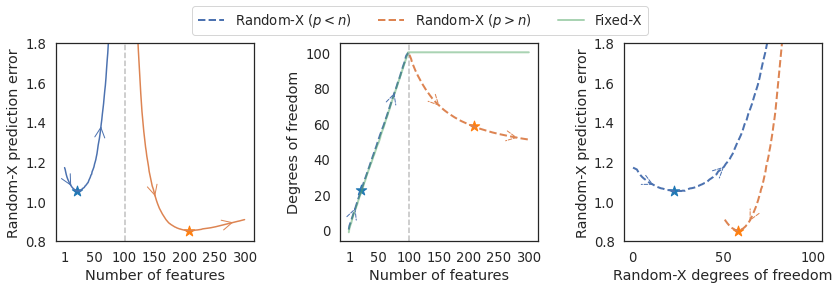

In [154]:
path_result = 'result/ex1/'
lam = 0.
method = 'partial_ridge'
predictor = 'mn2ls'

n=100; d=300; sigma = 0.4; func='quad'; coef = 'sorted'
sigma2 = sigma**2
df_res = pd.read_csv('{}res_emp_{}_{}_{}_{}_{}_{:.02f}.csv'.format(
        path_result, method, n, d, func, coef, sigma))

df_res = df_res.groupby(['n','d','sigma','type','method','lam','p']).mean()
df_res = df_res.reset_index()
df_res['dof_F'] = (df_res['err_F'] - df_res['err_T']) / (2*sigma2) * n
df_res['dof_R'] = comp_dof(df_res['err_R'], df_res['err_T'], sigma2) * n
df_res.loc[df_res['type']!='emergent','err_R'] = df_res[df_res['type']=='emergent']['err_R'].values


fig, axes = plt.subplots(1,3,figsize=(12,4))

sns.lineplot(data=df_res[(df_res['type']!='intrinsic')&(df_res['p']<df_res['n'])], x='p', y='err_R', ax=axes[0])
sns.lineplot(data=df_res[(df_res['type']!='intrinsic')&(df_res['p']>df_res['n'])], x='p', y='err_R', ax=axes[0])


for i,j in itertools.product(range(2),range(1,2)):
    _df = df_res[((df_res['type']!='intrinsic') if j==0 else (df_res['type']=='intrinsic')) & 
                 ((df_res['p']<df_res['n']) if i==0 else (df_res['p']>df_res['n']))].reset_index()
    idx = _df['err_R'].idxmin()
    scatter(axes, idx, _df, marker='*', s=120, color=sns.color_palette("tab10")[i])

sns.lineplot(data=df_res[(df_res['p']<df_res['n'])&(df_res['type']=='intrinsic')], x='p', y='dof_R', linestyle='--', lw=2, ax=axes[1], label='1', legend='full')
sns.lineplot(data=df_res[(df_res['p']>df_res['n'])&(df_res['type']=='intrinsic')], x='p', y='dof_R', linestyle='--', lw=2, ax=axes[1], label='2', legend='full')

sns.lineplot(data=df_res[(df_res['type']!='intrinsic')], x='p', y='dof_F', ax=axes[1], linestyle='-', lw=2, alpha=0.5, label='Fix-X DoF')

sns.lineplot(data=df_res[(df_res['p']<df_res['n'])&(df_res['type']=='intrinsic')], x='dof_R', y='err_R', linestyle='--', lw=2, ax=axes[2])
sns.lineplot(data=df_res[(df_res['p']>df_res['n'])&(df_res['type']=='intrinsic')], x='dof_R', y='err_R', linestyle='--', lw=2, ax=axes[2])

add_arrow(axes[0].get_lines()[0], 10, size=25)
add_arrow(axes[0].get_lines()[0], 60, size=25)
add_arrow(axes[0].get_lines()[1], 150, size=25)
add_arrow(axes[0].get_lines()[1], 280, size=25)

add_arrow(axes[1].get_lines()[0], 10, size=25, linestyle='--')
add_arrow(axes[1].get_lines()[0], 75, size=25, linestyle='--')
add_arrow(axes[1].get_lines()[1], 150, size=25, linestyle='--')
add_arrow(axes[1].get_lines()[1], 280, size=25, linestyle='--')

add_arrow(axes[2].get_lines()[0], n*0.1, size=25, linestyle='--', direction='right')
add_arrow(axes[2].get_lines()[0], n*0.5, size=25, linestyle='--', direction='right')
add_arrow(axes[2].get_lines()[1], n*0.65, size=25, linestyle='--', direction='left')

for j in range(2):
    ylim = axes[j].get_ylim()
    axes[j].axvline(100, color='gray', alpha=0.5, ls='--')
    axes[j].set_ylim(ylim)
    x = [1,50,100,150, 200,250,300]
    axes[j].set_xticks(x, x)
    
for j in [0,2]:
    axes[j].set_ylim([0.8,1.8])
for j in range(3):
    axes[j].set_box_aspect(1)

axes[0].set_ylabel('Random-X prediction error')
axes[1].set_ylabel('Degrees of freedom')
axes[2].set_ylabel('Random-X prediction error')

axes[0].set_xlabel('Number of features')
axes[1].set_xlabel('Number of features')
axes[2].set_xlabel('Random-X degrees of freedom')


lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]

handles = [handles[0], handles[1], handles[2]]
labels = [
          'Random-X ($p<n$)', 'Random-X ($p>n$)', 'Fixed-X'
]

axes[1].get_legend().remove()
# axes[2].get_legend().remove()
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=3, title=None)
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.85)

plt.savefig('result/fig_{}_intrinsic.pdf'.format(predictor), dpi=300, bbox_inches='tight')

## Ridge (Figure 11)

['emergent', 'intrinsic', 'Fix-X DoF']


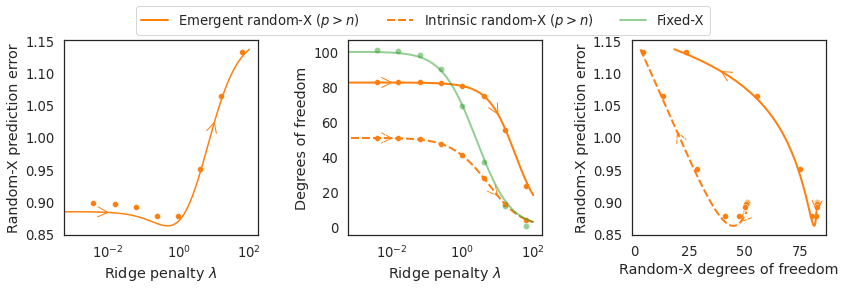

In [37]:
path_result = 'result/ex1/'
method = 'ridge'
sigma = 0.4; n = 100; d = 300; func='quad'; coef = 'sorted'
sigma2 = sigma**2
df_res = pd.read_csv('{}res_emp_{}_{}_{}_{}_{}_{:.02f}.csv'.format(
        path_result, method, n, d, func, coef, sigma))
df_res = df_res.groupby(['n','d','sigma2','type','method','lam']).mean()
df_res = df_res.reset_index()
df_res['dof_F'] = (df_res['err_F'] - df_res['err_T']) / (2*sigma2) * n
df_res['dof_R'] = comp_dof(df_res['err_R'], df_res['err_T'], sigma2) * n
df_res.loc[df_res['type']!='emergent','err_R'] = df_res[df_res['type']=='emergent']['err_R'].values
df_res = df_res[df_res['lam'].isin(df_res['lam'].unique()[::30])]


df_thm = pd.read_csv('{}res_theory_{}_{}_{}_{}_{}_{:.02f}.csv'.format(
        path_result, method, n, d, func, coef, sigma))
df_thm = pd.wide_to_long(df_thm, stubnames=r'dof_R', i=['n','d','lam','seed'], j='type', sep='_', suffix='(i|e)').reset_index()
df_thm['type'] = df_thm['type'].map({'i':'intrinsic','e':'emergent'})
df_thm = df_thm.groupby(['n','d','type','lam']).mean().reset_index()
df_thm['dof_F'] *= n
df_thm['dof_R'] *= n


fig, axes = plt.subplots(1,3,figsize=(12,4))

sns.lineplot(data=df_thm[(df_thm['type']!='intrinsic')], x='lam', y='err_R', 
             c=sns.color_palette("tab10")[1], ax=axes[0])
sns.lineplot(data=df_thm, x='lam', y='dof_R', style='type', lw=2,
             ax=axes[1], c=sns.color_palette("tab10")[1])
sns.lineplot(data=df_thm[(df_thm['type']!='intrinsic')], x='lam', y='dof_F', 
             linestyle='-', lw=2, alpha=0.5, c=sns.color_palette("tab10")[2], ax=axes[1], label='Fix-X DoF')
sns.lineplot(data=df_thm, x='dof_R', y='err_R', style='type',lw=2,
             c=sns.color_palette("tab10")[1], ax=axes[2])


sns.scatterplot(data=df_res[(df_res['type']!='intrinsic')], x='lam', y='err_R', 
             color=sns.color_palette("tab10")[1], ax=axes[0])

sns.scatterplot(data=df_res, x='lam', y='dof_R',
             ax=axes[1], color=sns.color_palette("tab10")[1])
sns.scatterplot(data=df_res[(df_res['type']!='intrinsic')], x='lam', y='dof_F', 
             alpha=0.5, color=sns.color_palette("tab10")[2], ax=axes[1])
sns.scatterplot(data=df_res, x='dof_R', y='err_R',
             color=sns.color_palette("tab10")[1], ax=axes[2])


    
axes[0].set_ylabel('Random-X prediction error')
axes[1].set_ylabel('Degrees of freedom')
axes[2].set_ylabel('Random-X prediction error')

axes[0].set_xlabel('Ridge penalty $\lambda$')
axes[1].set_xlabel('Ridge penalty $\lambda$')
axes[2].set_xlabel('Random-X degrees of freedom')


add_arrow(axes[0].get_lines()[0], 0.01, size=25)
add_arrow(axes[0].get_lines()[0], 10, size=25)

add_arrow(axes[1].get_lines()[0], 0.01, size=25)
add_arrow(axes[1].get_lines()[0], 10, size=25)
add_arrow(axes[1].get_lines()[1], 0.01, size=25, linestyle='--')
add_arrow(axes[1].get_lines()[1], 10, size=25, linestyle='--')

add_arrow(axes[2].get_lines()[0], 40, size=25, direction='left')
add_arrow(axes[2].get_lines()[0], 83, size=25, direction='left')
add_arrow(axes[2].get_lines()[1], 20, size=25, linestyle='--', direction='left')
add_arrow(axes[2].get_lines()[1], 48, size=25, linestyle='--', direction='left')

for j in range(2):
    axes[j].set_xscale('log')
for j in range(3):
    axes[j].set_box_aspect(1)
lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
print(labels)

axes[1].get_legend().remove()
axes[2].get_legend().remove()

handles = [handles[0], handles[1], handles[-1],  ]
labels = ['Emergent random-X ($p > n$)','Intrinsic random-X ($p > n$)','Fixed-X']
legend = fig.legend(handles=handles, labels=labels, loc=9, ncol=3, title=None)
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.86)

plt.savefig('result/fig_ridge_overparameterized.pdf', dpi=300, bbox_inches='tight')

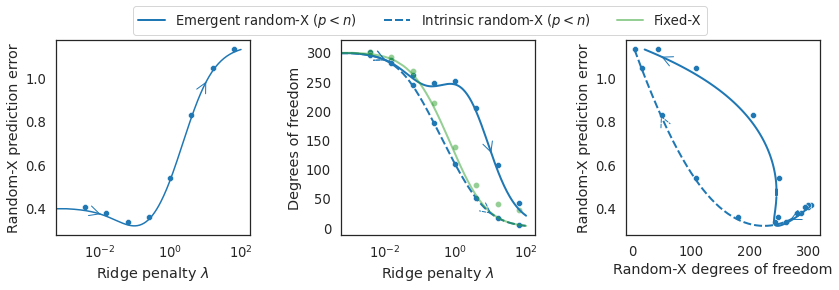

In [38]:
path_result = 'result/ex1/'
method = 'ridge'
sigma = 0.4; sigma2 = sigma**2
n = 500;d = 300;func='quad';coef = 'sorted'

df_res = pd.read_csv('{}res_emp_{}_{}_{}_{}_{}_{:.02f}.csv'.format(
        path_result, method, n, d, func, coef, sigma))
df_res = df_res.groupby(['n','d','sigma2','type','method','lam']).mean()
df_res = df_res.reset_index()
df_res['dof_F'] = (df_res['err_F'] - df_res['err_T']) / (2*sigma2) * n
df_res['dof_R'] = comp_dof(df_res['err_R'], df_res['err_T'], sigma2) * n
df_res.loc[df_res['type']!='emergent','err_R'] = df_res[df_res['type']=='emergent']['err_R'].values
df_res = df_res[df_res['lam'].isin(df_res['lam'].unique()[::30])]


df_thm = pd.read_csv('{}res_theory_{}_{}_{}_{}_{}_{:.02f}.csv'.format(
        path_result, method, n, d, func, coef, sigma))
df_thm = pd.wide_to_long(df_thm, stubnames=r'dof_R', i=['n','d','lam','seed'], j='type', sep='_', suffix='(i|e)').reset_index()
df_thm['type'] = df_thm['type'].map({'i':'intrinsic','e':'emergent'})
df_thm = df_thm.groupby(['n','d','type','lam']).mean().reset_index()
df_thm['dof_F'] *= n
df_thm['dof_R'] *= n


fig, axes = plt.subplots(1,3,figsize=(12,4))

sns.lineplot(data=df_thm[(df_thm['type']!='intrinsic')], x='lam', y='err_R', 
             c=sns.color_palette("tab10")[0], ax=axes[0])
sns.lineplot(data=df_thm, x='lam', y='dof_R', style='type', lw=2,
             ax=axes[1], c=sns.color_palette("tab10")[0])
sns.lineplot(data=df_thm[(df_thm['type']!='intrinsic')], x='lam', y='dof_F', 
             linestyle='-', lw=2, alpha=0.5, c=sns.color_palette("tab10")[2], ax=axes[1], label='Fix-X DoF')

idx = (df_thm['type']!='intrinsic')&(df_thm['dof_R']>240)&(df_thm['err_R']<0.45)
sns.lineplot(data=df_thm[~idx], x='dof_R', y='err_R', style='type', lw=2, c=sns.color_palette("tab10")[0], ax=axes[2])
plt.plot(df_thm.loc[idx]['dof_R'], df_thm.loc[idx]['err_R'], lw=2, c=sns.color_palette("tab10")[0])
    

sns.scatterplot(data=df_res[(df_res['type']!='intrinsic')], x='lam', y='err_R', 
             color=sns.color_palette("tab10")[0], ax=axes[0])

# for j in range(2):
#     _df = df_thm[((df_thm['type']!='intrinsic') if j==0 else (df_thm['type']=='intrinsic'))].reset_index()
#     idx = _df['err_R'].idxmin()
#     scatter(axes, idx, _df, marker='*', s=120, color=sns.color_palette("tab10")[0])

sns.scatterplot(data=df_res, x='lam', y='dof_R', #lw=2,
             ax=axes[1], color=sns.color_palette("tab10")[0])
sns.scatterplot(data=df_res[(df_res['type']!='intrinsic')], x='lam', y='dof_F', 
             #lw=2, 
             alpha=0.5, color=sns.color_palette("tab10")[2], ax=axes[1])
sns.scatterplot(data=df_res, x='dof_R', y='err_R', #lw=2,
             color=sns.color_palette("tab10")[0], ax=axes[2])


    
axes[0].set_ylabel('Random-X prediction error')
axes[1].set_ylabel('Degrees of freedom')
axes[2].set_ylabel('Random-X prediction error')

axes[0].set_xlabel('Ridge penalty $\lambda$')
axes[1].set_xlabel('Ridge penalty $\lambda$')
axes[2].set_xlabel('Random-X degrees of freedom')

add_arrow(axes[0].get_lines()[0], 0.01, size=25)
add_arrow(axes[0].get_lines()[0], 10, size=25)

add_arrow(axes[1].get_lines()[0], 0.01, size=25)
add_arrow(axes[1].get_lines()[0], 10, size=25)
add_arrow(axes[1].get_lines()[1], 0.01, size=25, linestyle='--')
add_arrow(axes[1].get_lines()[1], 10, size=25, linestyle='--')

add_arrow(axes[2].get_lines()[0], 50, size=25, direction='left')
add_arrow(axes[2].get_lines()[1], 50, size=25, linestyle='--', direction='left')
add_arrow(axes[2].get_lines()[1], 270, size=25, direction='left')

for j in range(2):
    axes[j].set_xscale('log')
for j in range(3):
    axes[j].set_box_aspect(1)
lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
axes[1].get_legend().remove()
axes[2].get_legend().remove()
handles = [handles[0], handles[1], handles[-1],  ]
labels = ['Emergent random-X ($p < n$)','Intrinsic random-X ($p < n$)','Fixed-X']
legend = fig.legend(handles=handles, labels=labels, loc=9, ncol=3, title=None)
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.86)

plt.savefig('result/fig_ridge_underparametrized.pdf', dpi=300, bbox_inches='tight')

## Ridgeless in $\gamma$ (Figure 12)

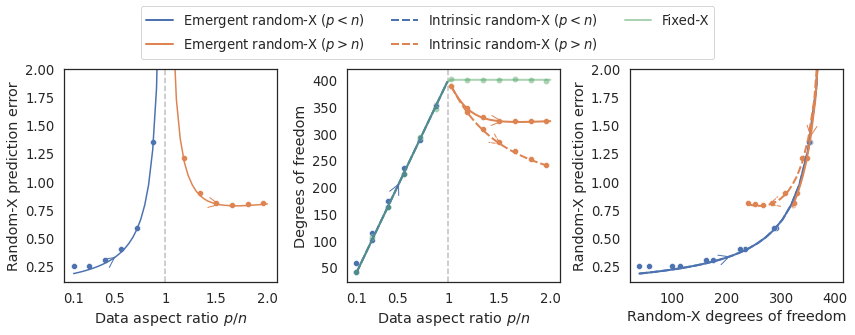

In [35]:
path_result = 'result/ex1/'
predictor = method = 'ridgeless'; lam = 0.

n = 400; sigma = .4;func='quad'; coef = 'sorted'; path_result = 'result/ex1/'
sigma2 = sigma**2
df_res = pd.read_csv('{}res_emp_{}_{}_{}_{}_{:.02f}.csv'.format(
        path_result, method, n, func, coef, sigma))
df_res = df_res.groupby(['n','gamma','sigma','type','method','lam']).mean()
df_res = df_res.reset_index()
df_res['dof_F'] = (df_res['err_F'] - df_res['err_T']) / (2*sigma2) * n
df_res['dof_R'] = comp_dof(df_res['err_R'], df_res['err_T'], sigma2) * n
df_res.loc[df_res['type']!='emergent','err_R'] = df_res[df_res['type']=='emergent']['err_R'].values
df_res = df_res[df_res['gamma'].isin(df_res['gamma'].unique()[::4])]

df_thm = pd.read_csv('{}res_theory_{}_{}_{}_{}_{:.02f}.csv'.format(
        path_result, method, n, func, coef, sigma))
df_thm = df_thm.drop_duplicates(['n','d','seed'])
df_thm = pd.wide_to_long(df_thm, stubnames=r'dof_R', i=['n','d','lam','seed'], j='type', sep='_', suffix='(i|e)').reset_index()
df_thm['type'] = df_thm['type'].map({'i':'intrinsic','e':'emergent'})
df_thm = df_thm.groupby(['n','d','type','lam']).mean().reset_index()
df_thm['gamma'] = df_thm['d']/df_thm['n']
df_thm['dof_F'] *= n
df_thm['dof_R'] *= n


fig, axes = plt.subplots(1,3,figsize=(12,4.5))

sns.lineplot(data=df_thm[(df_thm['type']!='intrinsic')&(df_thm['gamma']<1)], x='gamma', y='err_R', ax=axes[0])
sns.lineplot(data=df_thm[(df_thm['type']!='intrinsic')&(df_thm['gamma']>1)], x='gamma', y='err_R', ax=axes[0])

sns.lineplot(data=df_thm[(df_thm['gamma']<1)], x='gamma', y='dof_R', style='type', lw=2, ax=axes[1], legend='full')
sns.lineplot(data=df_thm[(df_thm['gamma']>1)], x='gamma', y='dof_R', style='type', lw=2, ax=axes[1], legend='full')

sns.lineplot(data=df_thm[(df_thm['type']!='intrinsic')], x='gamma', y='dof_F', ax=axes[1], linestyle='-', lw=2, alpha=0.5, label='Fix-X DoF')

sns.lineplot(data=df_thm[(df_thm['gamma']<1)], x='dof_R', y='err_R', style='type', lw=2, ax=axes[2])
sns.lineplot(data=df_thm[(df_thm['gamma']>1)], x='dof_R', y='err_R', style='type', lw=2, ax=axes[2])


sns.scatterplot(data=df_res[(df_res['type']!='intrinsic')&(df_res['gamma']<1)], x='gamma', y='err_R', ax=axes[0])
sns.scatterplot(data=df_res[(df_res['type']!='intrinsic')&(df_res['gamma']>1)], x='gamma', y='err_R', ax=axes[0])

sns.scatterplot(data=df_res[(df_res['gamma']<1)], x='gamma', y='dof_R', ax=axes[1], legend='full')
sns.scatterplot(data=df_res[(df_res['gamma']>1)], x='gamma', y='dof_R', ax=axes[1], legend='full')

sns.scatterplot(data=df_res[(df_res['type']!='intrinsic')], x='gamma', y='dof_F', ax=axes[1], linestyle='-', alpha=0.5, label='Fix-X DoF')

sns.scatterplot(data=df_res[(df_res['gamma']<1)], x='dof_R', y='err_R', ax=axes[2])
sns.scatterplot(data=df_res[(df_res['gamma']>1)], x='dof_R', y='err_R', ax=axes[2])

# axes[0].set_xscale('log')
# axes[1].set_xscale('log')

add_arrow(axes[0].get_lines()[0], 0.5, size=25)
add_arrow(axes[0].get_lines()[1], 1.5, size=25)

add_arrow(axes[1].get_lines()[0], 0.5, size=25)
add_arrow(axes[1].get_lines()[4], 1.5, size=25)

add_arrow(axes[1].get_lines()[5], 1.5, size=25, linestyle='--')

add_arrow(axes[2].get_lines()[0], 50*4, size=25, direction='right')
add_arrow(axes[2].get_lines()[4], 90*4, size=25, direction='left')
add_arrow(axes[2].get_lines()[5], 70*4, size=25, linestyle='--', direction='left')


for j in range(2):
    ylim = axes[j].get_ylim()
    axes[j].axvline(1, color='gray', alpha=0.5, ls='--')
    axes[j].set_ylim(ylim)

    x = [0.1, 0.5, 1, 1.5, 2.]
    axes[j].set_xticks(x, x)    
    
for j in [0,2]:
    axes[j].set_ylim([0.1,2])
for j in range(3):
    axes[j].set_box_aspect(1)

axes[0].set_ylabel('Random-X prediction error')
axes[1].set_ylabel('Degrees of freedom')
axes[2].set_ylabel('Random-X prediction error')

axes[0].set_xlabel('Data aspect ratio $p/n$')
axes[1].set_xlabel('Data aspect ratio $p/n$')
axes[2].set_xlabel('Random-X degrees of freedom')


lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]

handles = [handles[0], handles[2], handles[1], handles[3], handles[-2],  ]
labels = ['Emergent random-X ($p<n$)', 'Emergent random-X ($p>n$)',
          'Intrinsic random-X ($p<n$)', 'Intrinsic random-X ($p>n$)', 'Fixed-X'
]

axes[1].get_legend().remove()
axes[2].get_legend().remove()
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=3, title=None)
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.8)

plt.savefig('result/fig_{}.pdf'.format(predictor), dpi=300, bbox_inches='tight')

## Lasso (Figure 13)

In [68]:
path_result = 'result/ex1/'
method = 'lasso-iso'
sigma = 1.; coef = 'sparse-100'
n = 400
df_res = pd.DataFrame()
_df = pd.read_csv('{}res_{}_{}_{}_{:.02f}.csv'.format(
        path_result, method, n, coef, sigma))
df_res = pd.concat([df_res, _df])

sigma2 = sigma**2
df_res = df_res.groupby(['n','d','sigma','type','lam']).mean().reset_index()
df_res['dof_F'] = (df_res['err_F'] - df_res['err_T']) / (2*sigma2) * n
df_res['dof_R'] = comp_dof(df_res['err_R'], df_res['err_T'], sigma2) * n
df_res.loc[df_res['type']!='emergent','err_R'] = df_res[df_res['type']=='emergent']['err_R'].values

df_thm = pd.read_csv('{}res_risk_{}_{}_{}_{:.02f}.csv'.format(
        path_result, method, n, coef, sigma))
df_thm.loc[df_thm['type']!='emergent','err_R'] = df_thm[df_thm['type']=='emergent']['err_R'].values
df_thm['dof_F'] *= n
df_thm['dof_R'] *= n
df_res = df_res[df_res['lam'].isin(np.unique(df_res['lam'])[::3])]

['emergent', 'intrinsic', 'emergent', 'intrinsic', 'emergent', 'Fix-X DoF']


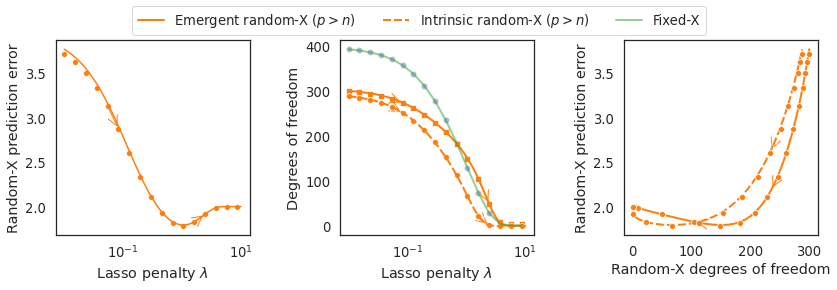

In [55]:
fig, axes = plt.subplots(1,3,figsize=(12,4))

sns.lineplot(data=df_res[(df_res['type']!='intrinsic')], x='lam', y='err_R', 
        linestyle='', marker='o', c=sns.color_palette("tab10")[1], ax=axes[0])
sns.lineplot(data=df_thm[(df_thm['type']!='intrinsic')], x='lam', y='err_R', 
        c=sns.color_palette("tab10")[1], ax=axes[0])

sns.lineplot(data=df_res, x='lam', y='dof_R', style='type', linestyle='-', dashes=[(0.1, 10),(0.1, 10)], markers=['s','o'], lw=2, c=sns.color_palette("tab10")[1], ax=axes[1])
sns.lineplot(data=df_thm, x='lam', y='dof_R', style='type', lw=2, c=sns.color_palette("tab10")[1], ax=axes[1])
sns.lineplot(data=df_res[df_res['type']!='intrinsic'], x='lam', y='dof_F', style='type',
             ax=axes[1], linestyle='-', lw=2, alpha=0.5, c=sns.color_palette("tab10")[2])


sns.lineplot(data=df_thm, x='dof_R', y='err_R', style='type', lw=2, c=sns.color_palette("tab10")[1], ax=axes[2])
sns.lineplot(data=df_res[(df_res['type']=='emergent')], x='dof_R', y='err_R', 
             style='type', ls='-', dashes=[(0.1, 10),(0.1, 10)], markers=['o','o'], lw=2, c=sns.color_palette("tab10")[1], ax=axes[2])
sns.lineplot(data=df_res[(df_res['type']!='emergent')], x='dof_R', y='err_R',
             style='type', ls='-', dashes=[(0.1, 10),(0.1, 10)], markers=['o','o'], lw=2, c=sns.color_palette("tab10")[1], ax=axes[2])
sns.scatterplot(data=df_res[(df_res['type']!='intrinsic')], x='lam', y='dof_F', ax=axes[1], linestyle='-', alpha=0.5, label='Fix-X DoF')

add_arrow(axes[0].get_lines()[0], 0.05, size=25)
add_arrow(axes[0].get_lines()[0], 2, size=25)

add_arrow(axes[1].get_lines()[0], 0.05, size=25)
add_arrow(axes[1].get_lines()[0], 2, size=25)
add_arrow(axes[1].get_lines()[1], 0.05, size=25, linestyle='--')
add_arrow(axes[1].get_lines()[1], 2, size=25, linestyle='--')

add_arrow(axes[2].get_lines()[0], 0.6*n, size=25, direction='left')
add_arrow(axes[2].get_lines()[0], 0.3*n, size=25, direction='left')
add_arrow(axes[2].get_lines()[1], 0.6*n, size=25, direction='left', linestyle='--')

for j in range(2):
    axes[j].set_xscale('log')
    axes[j].set_xlabel('Lasso penalty $\lambda$')
for j in range(3):
    axes[j].set_box_aspect(1)    
axes[0].set_ylabel('Random-X prediction error')
axes[1].set_ylabel('Degrees of freedom')
axes[2].set_ylabel('Random-X prediction error')
axes[2].set_xlabel('Random-X degrees of freedom')


lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
print(labels)
axes[1].get_legend().remove()
axes[2].get_legend().remove()
handles = [handles[2], 
           handles[3], 
           handles[4]]
labels = ['Emergent random-X ($p>n$)', 'Intrinsic random-X ($p>n$)', 'Fixed-X']
legend = fig.legend(handles=handles, labels=labels, loc=9, ncol=3, title=None)
legend_title_left(legend)
fig.tight_layout()
fig.subplots_adjust(top=0.86)

plt.savefig('result/fig_lasso_iso_lam_over.pdf', dpi=300, bbox_inches='tight')

In [69]:
path_result = 'result/ex1/'
method = 'lasso-iso'
sigma = 1.; coef = 'sparse-100'
n = 800
df_res = pd.DataFrame()
_df = pd.read_csv('{}res_{}_{}_{}_{:.02f}.csv'.format(
        path_result, method, n, coef, sigma))
df_res = pd.concat([df_res, _df])

sigma2 = sigma**2
df_res = df_res.groupby(['n','d','sigma','type','lam']).mean().reset_index()
df_res['dof_F'] = (df_res['err_F'] - df_res['err_T']) / (2*sigma2) * n
df_res['dof_R'] = comp_dof(df_res['err_R'], df_res['err_T'], sigma2) * n
df_res.loc[df_res['type']!='emergent','err_R'] = df_res[df_res['type']=='emergent']['err_R'].values

df_thm = pd.read_csv('{}res_risk_{}_{}_{}_{:.02f}.csv'.format(
        path_result, method, n, coef, sigma))
df_thm.loc[df_thm['type']!='emergent','err_R'] = df_thm[df_thm['type']=='emergent']['err_R'].values
df_thm['dof_F'] *= n
df_thm['dof_R'] *= n
df_res = df_res[df_res['lam'].isin(np.unique(df_res['lam'])[::3])]

['emergent', 'intrinsic', 'emergent', 'intrinsic', 'emergent', 'Fix-X DoF']


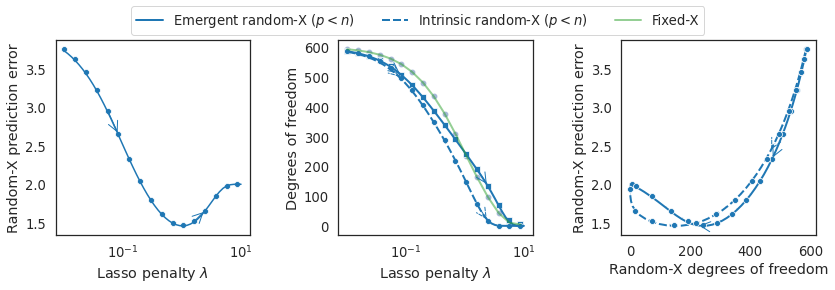

In [70]:
fig, axes = plt.subplots(1,3,figsize=(12,4))
sns.set(font_scale=1.2, style = "white")

sns.lineplot(data=df_res[(df_res['type']!='intrinsic')], x='lam', y='err_R', 
        linestyle='', marker='o', c=sns.color_palette("tab10")[0], ax=axes[0])
sns.lineplot(data=df_thm[(df_thm['type']!='intrinsic')], x='lam', y='err_R', 
        c=sns.color_palette("tab10")[0], ax=axes[0])

sns.lineplot(data=df_res, x='lam', y='dof_R', style='type', linestyle='-', dashes=[(0.1, 10),(0.1, 10)], markers=['s','o'], lw=2, c=sns.color_palette("tab10")[0], ax=axes[1])
sns.lineplot(data=df_thm, x='lam', y='dof_R', style='type', lw=2, c=sns.color_palette("tab10")[0], ax=axes[1])
sns.lineplot(data=df_res[df_res['type']!='intrinsic'], x='lam', y='dof_F', style='type',
             ax=axes[1], linestyle='-', lw=2, alpha=0.5, c=sns.color_palette("tab10")[2])


sns.lineplot(data=df_thm, x='dof_R', y='err_R', style='type', lw=2, c=sns.color_palette("tab10")[0], ax=axes[2])
sns.lineplot(data=df_res[(df_res['type']=='emergent')], x='dof_R', y='err_R', 
             style='type', ls='-', dashes=[(0.1, 10),(0.1, 10)], markers=['o','o'], lw=2, c=sns.color_palette("tab10")[0], ax=axes[2])
sns.lineplot(data=df_res[(df_res['type']!='emergent')], x='dof_R', y='err_R',
             style='type', ls='-', dashes=[(0.1, 10),(0.1, 10)], markers=['o','o'], lw=2, c=sns.color_palette("tab10")[0], ax=axes[2])
sns.scatterplot(data=df_res[(df_res['type']!='intrinsic')], x='lam', y='dof_F', ax=axes[1], linestyle='-', alpha=0.5, label='Fix-X DoF')

add_arrow(axes[0].get_lines()[0], 0.05, size=25)
add_arrow(axes[0].get_lines()[0], 2, size=25)

add_arrow(axes[1].get_lines()[0], 0.05, size=25)
add_arrow(axes[1].get_lines()[0], 2, size=25)
add_arrow(axes[1].get_lines()[1], 0.05, size=25, linestyle='--')
add_arrow(axes[1].get_lines()[1], 2, size=25, linestyle='--')

add_arrow(axes[2].get_lines()[0], 0.6*n, size=25, direction='left')
add_arrow(axes[2].get_lines()[0], 0.3*n, size=25, direction='left')
add_arrow(axes[2].get_lines()[1], 0.6*n, size=25, direction='left', linestyle='--')

for j in range(2):
    axes[j].set_xscale('log')
    axes[j].set_xlabel('Lasso penalty $\lambda$')
for j in range(3):
    axes[j].set_box_aspect(1)    
axes[0].set_ylabel('Random-X prediction error')
axes[1].set_ylabel('Degrees of freedom')
axes[2].set_ylabel('Random-X prediction error')
axes[2].set_xlabel('Random-X degrees of freedom')


lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
print(labels)
axes[1].get_legend().remove()
axes[2].get_legend().remove()
handles = [handles[2], 
           handles[3], 
           handles[4]]
labels = ['Emergent random-X ($p<n$)', 'Intrinsic random-X ($p<n$)', 'Fixed-X']
legend = fig.legend(handles=handles, labels=labels, loc=9, ncol=3, title=None)
legend_title_left(legend)
fig.tight_layout()
fig.subplots_adjust(top=0.86)

plt.savefig('result/fig_lasso_iso_lam_under.pdf', dpi=300, bbox_inches='tight')

## Lassoless (Figure 14)

In [72]:
path_result = 'result/ex1/'
method = 'lassoless-iso'
sigma = 1.; coef = 'sparse-0.1';n = 400
df_res = pd.DataFrame()
_df = pd.read_csv('{}res_{}_{}_{:.02f}.csv'.format(
        path_result, method, coef, sigma))
df_res = pd.concat([df_res, _df])

sigma2 = sigma**2
df_res = df_res.groupby(['n','d','sigma','type','lam']).mean().reset_index()
df_res['dof_F'] = (df_res['err_F'] - df_res['err_T']) / (2*sigma2) * df_res['n']
df_res['dof_R'] = comp_dof(df_res['err_R'], df_res['err_T'], sigma2) * df_res['n']
df_res.loc[df_res['type']!='emergent','err_R'] = df_res[df_res['type']=='emergent']['err_R'].values
df_res['gamma'] = df_res['d'] / df_res['n']

df_thm = pd.read_csv('{}res_risk_{}_{}_{:.02f}.csv'.format(
        path_result, method, coef, sigma))
df_thm.loc[df_thm['type']!='emergent','err_R'] = df_thm[df_thm['type']=='emergent']['err_R'].values
df_thm['gamma'] = df_thm['phi']
df_thm['dof_F'] *= n
df_thm['dof_R'] *= n
df_res = df_res[df_res['gamma'].isin(np.unique(df_res['gamma'])[::2])]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


['emergent', 'intrinsic', 'emergent', 'intrinsic', 'Fix-X DoF', 'emergent', 'intrinsic', 'emergent', 'intrinsic', 'Fix-X DoF']


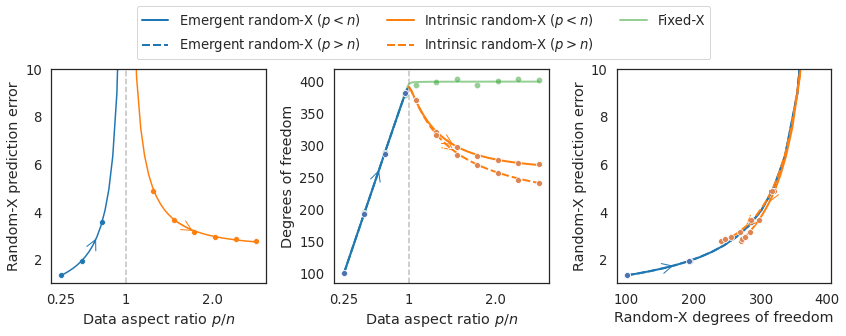

In [73]:
from matplotlib.legend_handler import HandlerTuple
sns.set(font_scale=1.2, style = "white")

fig, axes = plt.subplots(1,3,figsize=(12,4.5))

sns.lineplot(data=df_res[(df_res['type']!='intrinsic')&(df_res['gamma']<1)], x='gamma', y='err_R', ax=axes[0], c=sns.color_palette("tab10")[0], linestyle='', marker='o')
sns.lineplot(data=df_res[(df_res['type']!='intrinsic')&(df_res['gamma']>1)], x='gamma', y='err_R', ax=axes[0], c=sns.color_palette("tab10")[1], linestyle='', marker='o')

sns.lineplot(data=df_thm[(df_thm['type']!='intrinsic')&(df_thm['gamma']<1)], x='gamma', y='err_R', ax=axes[0], c=sns.color_palette("tab10")[0])
sns.lineplot(data=df_thm[(df_thm['type']!='intrinsic')&(df_thm['gamma']>1)], x='gamma', y='err_R', ax=axes[0], c=sns.color_palette("tab10")[1])

sns.lineplot(data=df_thm[(df_thm['gamma']<1)], x='gamma', y='dof_R', style='type', lw=2, ax=axes[1], c=sns.color_palette("tab10")[0], legend='full')
sns.lineplot(data=df_thm[(df_thm['gamma']>=1)], x='gamma', y='dof_R', style='type', lw=2, ax=axes[1], c=sns.color_palette("tab10")[1], legend='full')
sns.lineplot(data=df_thm[(df_thm['gamma']<1)], x='dof_R', y='err_R', style='type', lw=2, ax=axes[2], c=sns.color_palette("tab10")[0])
sns.lineplot(data=df_thm[(df_thm['gamma']>=1)], x='dof_R', y='err_R', style='type', lw=2, ax=axes[2], c=sns.color_palette("tab10")[1])

sns.lineplot(data=df_thm[(df_thm['type']!='intrinsic')], x='gamma', y='dof_F', ax=axes[1], linestyle='-', lw=2, alpha=0.5, label='Fix-X DoF', c=sns.color_palette("tab10")[2], zorder=0)


sns.lineplot(data=df_res[(df_res['gamma']<1)], x='gamma', y='dof_R', style='type', lw=2, ax=axes[1], linestyle='-', dashes=[(0., 10),(0., 10)], markers=['o','o'], legend='full')
sns.lineplot(data=df_res[(df_res['gamma']>=1)], x='gamma', y='dof_R', style='type', lw=2, ax=axes[1], linestyle='-', dashes=[(0., 10),(0., 10)], markers=['o','o'], legend='full')
sns.lineplot(data=df_res[(df_res['gamma']<1)], x='dof_R', y='err_R', style='type', lw=2, ax=axes[2], linestyle='-', dashes=[(0., 10),(0., 10)], markers=['o','o'])
sns.lineplot(data=df_res[(df_res['gamma']>=1)], x='dof_R', y='err_R', style='type', lw=2, ax=axes[2], linestyle='-', dashes=[(0., 10),(0., 10)], markers=['o','o'])
sns.scatterplot(data=df_res[(df_res['type']!='intrinsic')], x='gamma', y='dof_F', ax=axes[1], linestyle='-', alpha=0.5, label='Fix-X DoF', c=sns.color_palette("tab10")[2], zorder=0)


add_arrow(axes[0].get_lines()[2], 0.6, size=25)
add_arrow(axes[0].get_lines()[1], 1.5, size=25)

add_arrow(axes[1].get_lines()[0], 0.6, size=25)
add_arrow(axes[1].get_lines()[4], 1.5, size=25)
add_arrow(axes[1].get_lines()[5], 1.5, size=25, linestyle='--')

add_arrow(axes[2].get_lines()[0], 0.4*n, size=25, direction='right')
add_arrow(axes[2].get_lines()[4], 0.8*n, size=25, direction='left')
add_arrow(axes[2].get_lines()[5], 0.7*n, size=25, direction='left', linestyle='--')

# axes[0].set_xscale('log')
# axes[1].set_xscale('log')

for j in range(2):
    ylim = axes[j].get_ylim()
    axes[j].axvline(1, color='gray', alpha=0.5, ls='--')
    axes[j].set_ylim(ylim)
    x = [0.25, 1, 2.]
    axes[j].set_xticks(x, x)
    
for j in [0,2]:
    axes[j].set_ylim([1,10])
for j in range(3):
    axes[j].set_box_aspect(1)

axes[0].set_ylabel('Random-X prediction error')
axes[1].set_ylabel('Degrees of freedom')
axes[2].set_ylabel('Random-X prediction error')

axes[0].set_xlabel('Data aspect ratio $p/n$')
axes[1].set_xlabel('Data aspect ratio $p/n$')
axes[2].set_xlabel('Random-X degrees of freedom')


lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
print(labels)
handles = [handles[0],handles[1],handles[2],handles[3], handles[4]]

labels = ['Emergent random-X ($p<n$)', 'Emergent random-X ($p>n$)', 
          'Intrinsic random-X ($p<n$)', 'Intrinsic random-X ($p>n$)',
        'Fixed-X']

axes[1].get_legend().remove()
axes[2].get_legend().remove()
legend = fig.legend(handles=handles, labels=labels, loc=9, ncol=3, title=None, handler_map={tuple: HandlerTuple(ndivide=None)})
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.8)

plt.savefig('result/fig_lasso_iso_gamma.pdf', dpi=300, bbox_inches='tight')

# Ex2

## Lasso

### Underparameterized regime (Figure 4)

In [136]:
path_result = 'result/ex2/'

method = 'lasso'
solver = 'lars'
sigma = 1.; n = 200; d=30; func='linear'; sigma2 = sigma**2; s=10
design, coef = 'sparse','sparse-10'
df_res = pd.DataFrame()
df_res = pd.read_csv('{}res_{}_{}_{}_{}_{}_{}_{:.02f}.csv'.format(
    path_result, method, solver, n, d, func, coef, sigma))
df_res['design'] = design

df_res = df_res.groupby(['n','d','sigma','type','method','lam','design']).mean().reset_index()
df_res['dof_F'] = (df_res['err_F'] - df_res['err_T']) / (2*sigma2) * n
# comp_dof(df_res['err_F'], df_res['err_T'], sigma2) * n
# df_res['dof_F'] = df_res['dof_F'] * n
df_res['dof_R'] = comp_dof(df_res['err_R'], df_res['err_T'], sigma2) * n
nnz = df_res.groupby('type')['nnz'].max().min()
df_res.loc[(df_res['type']!='emergent'),'err_R'] = df_res[(df_res['type']=='emergent')]['err_R'].values


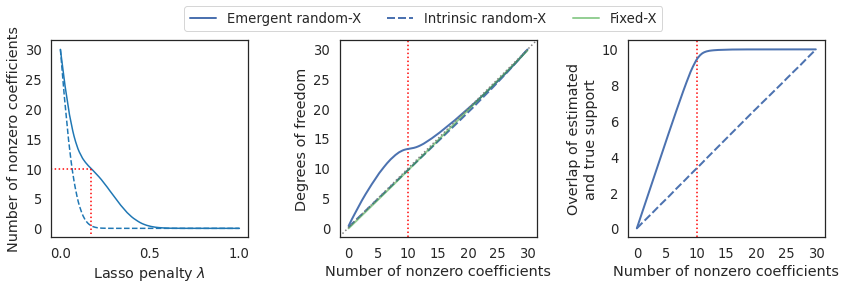

In [96]:
sns.set(style="white", font_scale=1.2)

fig, axes = plt.subplots(1,3,figsize=(12,4), sharex=False, sharey=False)


axes[0].plot(df_res[(df_res['type']!='intrinsic')]['lam'],
        df_res[(df_res['type']!='intrinsic')]['nnz'], label='$dof_R$',
            color=sns.color_palette("tab10")[0])

axes[0].plot(df_res[(df_res['type']=='intrinsic')]['lam'],
        df_res[(df_res['type']=='intrinsic')]['nnz'], label='$dof_R^i$', 
            color=sns.color_palette("tab10")[0], linestyle='--')
xlims = axes[0].get_xlim()
ylims = axes[0].get_ylim()
# axes[0].set_xscale('log')
axes[0].vlines(lam, -1, ymax=s, ls=':', color='red')
axes[0].hlines(s, -1, lam, ls=':', color='red')

axes[0].set_xlim(xlims)
axes[0].set_ylim(ylims)

sns.lineplot(data=df_res, style='type', lw=2,
             x='nnz', y='dof_R', ax=axes[1])
sns.lineplot(data=df_res[((df_res['type']=='emergent'))], 
             style='type', x='nnz', y='dof_F', 
             lw=2, alpha=0.5, c=sns.color_palette("tab10")[2], ax=axes[1])

sns.lineplot(data=df_res[(df_res['design']!='dense')], lw=2, style='type', x='nnz', y='nnz_tp', ax=axes[2])
axes[1].axline((0, 0), (d, d), ls=':', color='gray')

axes[0].set_xlabel('Lasso penalty $\lambda$')
axes[0].set_ylabel('Number of nonzero coefficients')
axes[1].set_ylabel('Degrees of freedom')
axes[2].set_ylabel('Overlap of estimated\nand true support')

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
x = [0,5,10,15, 20,25,30]
for ax in axes[1:]:
    ax.axvline(s, ls=':', color='red',zorder=-2)
    ax.set_xlabel('Number of nonzero coefficients')
    ax.set_xticks(x, x)
    ax.get_legend().remove()
for j in range(3):
    axes[j].set_box_aspect(1)    
handles = [handles[0], handles[1], handles[2]]
labels = ['Emergent random-X','Intrinsic random-X','Fixed-X']
legend = fig.legend(handles=handles, labels=labels, loc=9, ncol=4, title=None)

legend_title_left(legend)
fig.tight_layout()
fig.subplots_adjust(top=0.86)
plt.savefig('result/fig_lasso_supp_n_{}_p_{}_s_{}_sigma_{:.02f}.pdf'.format(n,d,s,sigma), dpi=300, bbox_inches='tight')

### Overparameterized regime (Figure 5)

In [122]:
path_result = 'result/ex2/'

method = 'lasso'
solver = 'lars'
sigma = 1.; n = 200; d=300; func='linear'; sigma2 = sigma**2; s=100
design, coef = 'sparse','sparse-100'
df_res = pd.DataFrame()
df_res = pd.read_csv('{}res_{}_{}_{}_{}_{}_{}_{:.02f}.csv'.format(
    path_result, method, solver, n, d, func, coef, sigma))
df_res['design'] = design

df_res = df_res.groupby(['n','d','sigma','type','method','lam','design']).mean().reset_index()
df_res['dof_F'] = (df_res['err_F'] - df_res['err_T']) / (2*sigma2) * n
# comp_dof(df_res['err_F'], df_res['err_T'], sigma2) * n
# df_res['dof_F'] = df_res['dof_F'] * n
df_res['dof_R'] = comp_dof(df_res['err_R'], df_res['err_T'], sigma2) * n
nnz = df_res.groupby('type')['nnz'].max().min()
df_res.loc[(df_res['type']!='emergent'),'err_R'] = df_res[(df_res['type']=='emergent')]['err_R'].values

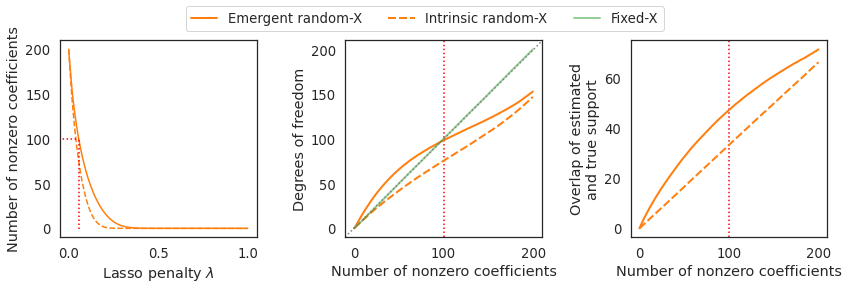

In [88]:
sns.set(style="white", font_scale=1.2)
fig, axes = plt.subplots(1,3,figsize=(12,4), sharex=False, sharey=False)

axes[0].plot(df_res[(df_res['type']!='intrinsic')]['lam'],
        df_res[(df_res['type']!='intrinsic')]['nnz'], label='$dof_R$',
            color=sns.color_palette("tab10")[1])

axes[0].plot(df_res[(df_res['type']=='intrinsic')]['lam'],
        df_res[(df_res['type']=='intrinsic')]['nnz'], label='$dof_R^i$', 
            color=sns.color_palette("tab10")[1], linestyle='--')
xlims = axes[0].get_xlim()
ylims = axes[0].get_ylim()
# axes[0].set_xscale('log')
axes[0].vlines(lam, -1, ymax=s, ls=':', color='red')
axes[0].hlines(s, -1, lam, ls=':', color='red')

axes[0].set_xlim(xlims)
axes[0].set_ylim(ylims)

sns.lineplot(data=df_res, style='type', lw=2,
             x='nnz', y='dof_R', c=sns.color_palette("tab10")[1], ax=axes[1])
sns.lineplot(data=df_res[((df_res['type']=='emergent'))], 
             style='type', x='nnz', y='dof_F', 
             lw=2, alpha=0.5, c=sns.color_palette("tab10")[2], ax=axes[1])

sns.lineplot(data=df_res[(df_res['design']!='dense')], lw=2, style='type', x='nnz', y='nnz_tp', 
            c=sns.color_palette("tab10")[1], ax=axes[2])

axes[1].axline((0, 0), (n, n), ls=':', color='gray')

axes[0].set_xlabel('Lasso penalty $\lambda$')
axes[0].set_ylabel('Number of nonzero coefficients')
axes[1].set_ylabel('Degrees of freedom')
axes[2].set_ylabel('Overlap of estimated\nand true support')

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]

x = [0, 100, 200]
for ax in axes[1:]:
    ax.axvline(s, ls=':', color='red',zorder=-2)
    ax.set_xlabel('Number of nonzero coefficients')
    ax.set_xticks(x, x)
    ax.get_legend().remove()
for j in range(3):
    axes[j].set_box_aspect(1)       
handles = [handles[0], handles[1], handles[2]]
labels = ['Emergent random-X','Intrinsic random-X','Fixed-X']
legend = fig.legend(handles=handles, labels=labels, loc=9, ncol=4, title=None)

legend_title_left(legend)
fig.tight_layout()
fig.subplots_adjust(top=0.86)
plt.savefig('result/fig_lasso_supp_n_{}_p_{}_s_{}_sigma_{:.02f}.pdf'.format(n,d,s,sigma), dpi=300, bbox_inches='tight')

## kNN

### Underparameterized regime (Figure 15)

In [134]:
path_result = 'result/ex2/'
method = 'kNN'

n = 500; d=300; sigma = 0.4; coef = 'sorted'; func='quad'

df_res = pd.read_csv('{}res_{}_{}_{}_{}_{}_{:.02f}.csv'.format(
        path_result, method, n, d, func, coef, sigma))


sigma2 = sigma**2

df_res = df_res.rename(columns={'lam': 'k'})
df_res = df_res.groupby(['n','d','sigma2','type','method','k']).mean()
df_res = df_res.reset_index()
df_res['dof_F'] = (df_res['err_F'] - df_res['err_T']) / (2*sigma2) * n
df_res['dof_R'] = comp_dof(df_res['err_R'], df_res['err_T'], sigma2) * n
df_res.loc[df_res['type']!='emergent','err_R'] = df_res[df_res['type']=='emergent']['err_R'].values


['emergent', 'intrinsic', 'Fixed-X']


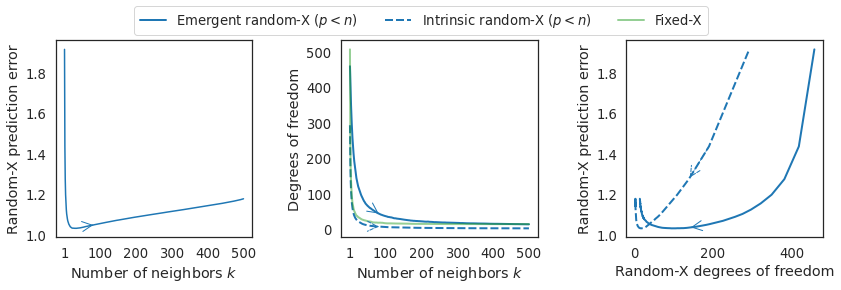

In [135]:
fig, axes = plt.subplots(1,3,figsize=(12,4))

sns.lineplot(data=df_res[(df_res['type']!='intrinsic')], x='k', y='err_R', 
             c=sns.color_palette("tab10")[0], ax=axes[0])

sns.lineplot(data=df_res, x='k', y='dof_R', style='type', lw=2, legend='full',
             c=sns.color_palette("tab10")[0], ax=axes[1])

sns.lineplot(data=df_res[df_res['type']!='intrinsic'], x='k', y='dof_F', ax=axes[1], linestyle='-', lw=2, label='Fixed-X',
             alpha=0.5, color=sns.color_palette("tab10")[2])

sns.lineplot(data=df_res, x='dof_R', y='err_R', style='type', lw=2, 
             c=sns.color_palette("tab10")[0], ax=axes[2])

    
for j in range(2):
    x = [1, 100, 200, 300, 400, 500]
    axes[j].set_xticks(x, x)
for j in range(3):
    axes[j].set_box_aspect(1)  
axes[0].set_ylabel('Random-X prediction error')
axes[1].set_ylabel('Degrees of freedom')
axes[2].set_ylabel('Random-X prediction error')

axes[0].set_xlabel('Number of neighbors $k$')
axes[1].set_xlabel('Number of neighbors $k$')
axes[2].set_xlabel('Random-X degrees of freedom')


add_arrow(axes[0].get_lines()[0], 80, size=25)

add_arrow(axes[1].get_lines()[0], 80, size=25)
add_arrow(axes[1].get_lines()[1], 80, size=25, linestyle='--')

add_arrow(axes[2].get_lines()[0], 0.3*n, size=25, direction='left')
add_arrow(axes[2].get_lines()[1], 0.4*n, size=25, direction='left', linestyle='--')


lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
print(labels)
axes[1].get_legend().remove()
axes[2].get_legend().remove()
handles = [handles[0], handles[1], handles[2],  ]
labels = ['Emergent random-X ($p < n$)','Intrinsic random-X ($p < n$)','Fixed-X'
]
legend = fig.legend(handles=handles, labels=labels, loc=9, ncol=3, title=None)
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.86)

plt.savefig('result/fig_kNN_under.pdf', dpi=300, bbox_inches='tight')

### Overparameterized regime (Figure 16)

In [129]:
path_result = 'result/ex2/'
method = 'kNN'

n = 200; d=300; sigma = 0.4; coef = 'sorted'; func='quad'

df_res = pd.read_csv('{}res_{}_{}_{}_{}_{}_{:.02f}.csv'.format(
        path_result, method, n, d, func, coef, sigma))


sigma2 = sigma**2

df_res = df_res.rename(columns={'lam': 'k'})
df_res = df_res.groupby(['n','d','sigma2','type','method','k']).mean()
df_res = df_res.reset_index()
df_res['dof_F'] = (df_res['err_F'] - df_res['err_T']) / (2*sigma2) * n
df_res['dof_R'] = comp_dof(df_res['err_R'], df_res['err_T'], sigma2) * n
df_res.loc[df_res['type']!='emergent','err_R'] = df_res[df_res['type']=='emergent']['err_R'].values


['emergent', 'intrinsic', 'Fixed-X']


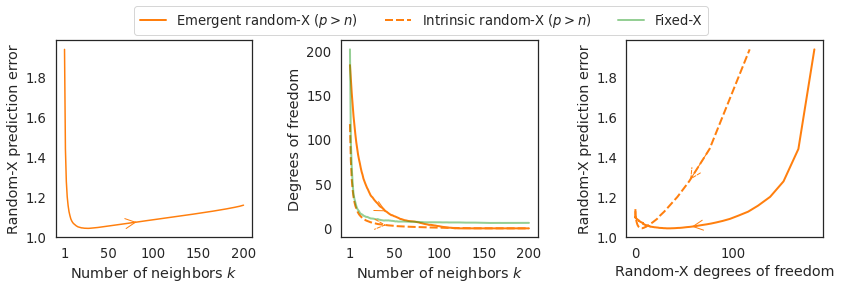

In [133]:
fig, axes = plt.subplots(1,3,figsize=(12,4))

sns.lineplot(data=df_res[(df_res['type']!='intrinsic')], x='k', y='err_R', 
             c=sns.color_palette("tab10")[1], ax=axes[0])

sns.lineplot(data=df_res, x='k', y='dof_R', style='type', lw=2, legend='full',
             c=sns.color_palette("tab10")[1], ax=axes[1])

sns.lineplot(data=df_res[df_res['type']!='intrinsic'], x='k', y='dof_F', ax=axes[1], linestyle='-', lw=2, label='Fixed-X',
             alpha=0.5, color=sns.color_palette("tab10")[2])

sns.lineplot(data=df_res, x='dof_R', y='err_R', style='type', lw=2, 
             c=sns.color_palette("tab10")[1], ax=axes[2])

    
for j in range(2):
    x = [1,50,100,150, 200]
    axes[j].set_xticks(x, x)
for j in range(3):
    axes[j].set_box_aspect(1)  
axes[0].set_ylabel('Random-X prediction error')
axes[1].set_ylabel('Degrees of freedom')
axes[2].set_ylabel('Random-X prediction error')

axes[0].set_xlabel('Number of neighbors $k$')
axes[1].set_xlabel('Number of neighbors $k$')
axes[2].set_xlabel('Random-X degrees of freedom')


add_arrow(axes[0].get_lines()[0], 80, size=25)

add_arrow(axes[1].get_lines()[0], 40, size=25)
add_arrow(axes[1].get_lines()[1], 40, size=25, linestyle='--')

add_arrow(axes[2].get_lines()[0], 0.3*n, size=25, direction='left')
add_arrow(axes[2].get_lines()[1], 0.4*n, size=25, direction='left', linestyle='--')


lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
print(labels)
axes[1].get_legend().remove()
axes[2].get_legend().remove()
handles = [handles[0], handles[1], handles[2],  ]
labels = ['Emergent random-X ($p > n$)','Intrinsic random-X ($p > n$)','Fixed-X'
]
legend = fig.legend(handles=handles, labels=labels, loc=9, ncol=3, title=None)
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.86)

plt.savefig('result/fig_kNN_over.pdf', dpi=300, bbox_inches='tight')

## Random forest (Figure 6)

In [104]:
path_result = 'result/ex2/'
method = 'random_forest'
sigma = 0.5; n=2000; d = 50; func='quad'; coef = 'random'; 

df_res = pd.read_csv('{}res_{}_{}_{}_{}_{}_{:.02f}.csv'.format(
        path_result, method, n, d, func, coef, sigma))

sigma2 = sigma**2

df_res = df_res.groupby(['n','d','sigma2','type','method','n_estimators', 'max_leaf_nodes']).mean()
df_res = df_res.reset_index()
df_res['dof_F'] = (df_res['err_F'] - df_res['err_T']) / (2*sigma2) * n
df_res['dof_R'] = comp_dof(df_res['err_R'], df_res['err_T'], sigma2) * n
df_res.loc[df_res['type']!='emergent','err_R'] = df_res[df_res['type']=='emergent']['err_R'].values


['emergent', 'intrinsic', 'emergent', 'intrinsic', 'Fix-X DoF']


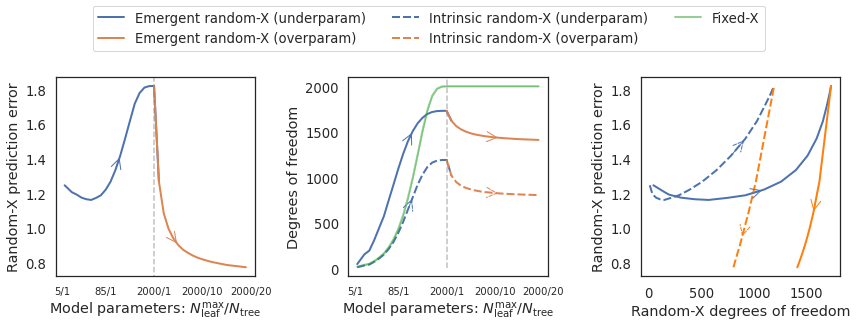

In [105]:
fig, axes = plt.subplots(1,3,figsize=(12,4.5))

sns.lineplot(data=df_res[(df_res['type']!='intrinsic')&(df_res['complexity']<=21)], x='complexity', y='err_R', lw=2, ax=axes[0])
sns.lineplot(data=df_res[(df_res['type']!='intrinsic')&(df_res['complexity']>=20)], x='complexity', y='err_R', lw=2, ax=axes[0])

sns.lineplot(data=df_res[(df_res['complexity']<=21)], x='complexity', y='dof_R', style='type', lw=2, ax=axes[1])
sns.lineplot(data=df_res[(df_res['complexity']>=20)], x='complexity', y='dof_R', style='type', lw=2, ax=axes[1])

sns.lineplot(data=df_res, x='complexity', y='dof_F', ax=axes[1], linestyle='-', lw=2, 
             alpha=0.5, color=sns.color_palette("tab10")[2], label='Fix-X DoF')

sns.lineplot(data=df_res[df_res['complexity']<=20], x='dof_R', y='err_R', style='type', lw=2,ax=axes[2])
sns.lineplot(data=df_res[df_res['complexity']>=20], x='dof_R', y='err_R', style='type', lw=2,
             color=sns.color_palette("tab10")[1], ax=axes[2])

for j in range(2):
    ylim = axes[j].get_ylim()
    axes[j].vlines(20, 0, 2*n, color='gray', alpha=0.5, ls='--')
    axes[j].set_ylim(ylim)
for j in range(3):
    axes[j].set_box_aspect(1)      
axes[0].set_ylabel('Random-X prediction error')
axes[1].set_ylabel('Degrees of freedom')
axes[2].set_ylabel('Random-X prediction error')

axes[0].set_xlabel('Model parameters: $N_{\mathrm{leaf}}^{\mathrm{max}}/N_{\mathrm{tree}}$')
axes[1].set_xlabel('Model parameters: $N_{\mathrm{leaf}}^{\mathrm{max}}/N_{\mathrm{tree}}$')
axes[2].set_xlabel('Random-X degrees of freedom')


add_arrow(axes[0].get_lines()[0], 12, size=25)
add_arrow(axes[0].get_lines()[1], 24, size=25)

add_arrow(axes[1].get_lines()[0], 12, size=25)
add_arrow(axes[1].get_lines()[1], 12, size=25, linestyle='--')
add_arrow(axes[1].get_lines()[4], 30, size=25)
add_arrow(axes[1].get_lines()[5], 30, size=25, linestyle='--')


add_arrow(axes[2].get_lines()[0], 0.5*n, size=25, direction='right')
add_arrow(axes[2].get_lines()[1], 0.4*n, size=25, direction='right', linestyle='--')
add_arrow(axes[2].get_lines()[4], 0.8*n, size=25, direction='left')
add_arrow(axes[2].get_lines()[5], 0.45*n, size=25, direction='left', linestyle='--')


lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
print(labels)
axes[1].get_legend().remove()
axes[2].get_legend().remove()
handles = [handles[0], handles[2], handles[1], handles[3], handles[4],  ]
labels = ['Emergent random-X (underparam)',
          'Emergent random-X (overparam)',
          'Intrinsic random-X (underparam)',          
          'Intrinsic random-X (overparam)', 'Fixed-X'
]
legend = fig.legend(handles=handles, labels=labels, loc=9, ncol=3, title=None)
legend_title_left(legend)

x = np.array([1,10,20,30,40])
labels = ['5/1', '85/1', '2000/1', '2000/10', '2000/20']
for j in range(2):
    axes[j].set_xticks(x, labels, fontsize=10)

fig.tight_layout()
fig.subplots_adjust(top=0.8)

plt.savefig('result/fig_random_forest.pdf', dpi=300, bbox_inches='tight')

## Random features (Figure 17)

In [2]:
path_result = 'result/ex2/'
func = 'quad'; rf_func_name = 'tanh'
sigma = .4
n = 100; d = 300
coef = 'random'

df_res = pd.read_csv('{}res_rf_{}_{}_{}_{}_{}_{:.02f}.csv'.format(
        path_result, rf_func_name, n, d, func, coef, sigma))

sigma2 = sigma**2
df_res = df_res.groupby(['n','d','type','method','lam','p']).mean()
df_res = df_res.reset_index()
df_res['dof_F'] = (df_res['err_F'] - df_res['err_T']) / (2*sigma2) * n
df_res['dof_R'] = comp_dof(df_res['err_R'], df_res['err_T'], sigma2) * n
df_res.loc[df_res['type']!='emergent','err_R'] = df_res[df_res['type']=='emergent']['err_R'].values

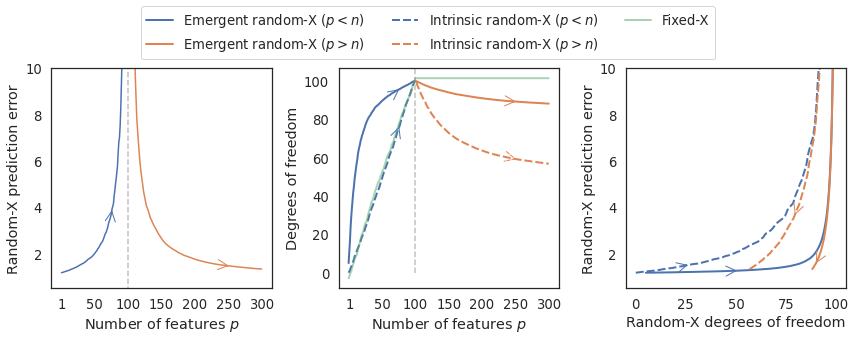

In [7]:
fig, axes = plt.subplots(1,3,figsize=(12,4.5))

sns.lineplot(data=df_res[(df_res['type']!='intrinsic')&(df_res['p']<df_res['n'])], x='p', y='err_R', ax=axes[0])
sns.lineplot(data=df_res[(df_res['type']!='intrinsic')&(df_res['p']>df_res['n'])], x='p', y='err_R', ax=axes[0])


sns.lineplot(data=df_res[(df_res['p']<df_res['n'])], x='p', y='dof_R', style='type', lw=2, ax=axes[1])
sns.lineplot(data=df_res[(df_res['p']>df_res['n'])], x='p', y='dof_R', style='type', lw=2, ax=axes[1])

sns.lineplot(data=df_res[(df_res['type']!='intrinsic')], x='p', y='dof_F', ax=axes[1], linestyle='-', lw=2, alpha=0.5, label='Fix-X DoF')
sns.lineplot(data=df_res[(df_res['p']<df_res['n'])], x='dof_R', y='err_R', style='type', lw=2, ax=axes[2])
sns.lineplot(data=df_res[(df_res['p']>df_res['n'])], x='dof_R', y='err_R', style='type', lw=2, ax=axes[2])


add_arrow(axes[0].get_lines()[0], 75, size=25)
add_arrow(axes[0].get_lines()[1], 250, size=25)

add_arrow(axes[1].get_lines()[0], 75, size=25)
add_arrow(axes[1].get_lines()[4], 250, size=25)

add_arrow(axes[1].get_lines()[1], 75, size=25)
add_arrow(axes[1].get_lines()[5], 250, size=25, linestyle='--')

add_arrow(axes[2].get_lines()[0], 0.5*n, size=25, direction='right')
add_arrow(axes[2].get_lines()[1], 0.25*n, size=25, direction='right')

add_arrow(axes[2].get_lines()[4], 0.9*n, size=25, direction='left')
add_arrow(axes[2].get_lines()[5], 0.8*n, size=25, direction='left')

for j in range(2):
    ylim = axes[j].get_ylim()
    axes[j].vlines(100, 0, 200, color='gray', alpha=0.5, ls='--')
    axes[j].set_ylim(ylim)
    x = [1,50,100,150, 200,250,300]
    axes[j].set_xticks(x, x)
    
for j in [0,2]:
    axes[j].set_ylim([0.5,10.])
for j in range(3):
    axes[j].set_box_aspect(1)

axes[0].set_ylabel('Random-X prediction error')
axes[1].set_ylabel('Degrees of freedom')
axes[2].set_ylabel('Random-X prediction error')

axes[0].set_xlabel('Number of features $p$')
axes[1].set_xlabel('Number of features $p$')
axes[2].set_xlabel('Random-X degrees of freedom')


lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
handles = [handles[0], handles[2], handles[1], handles[3], handles[-1],  ]
labels = ['Emergent random-X ($p<n$)', 'Emergent random-X ($p>n$)',
          'Intrinsic random-X ($p<n$)', 'Intrinsic random-X ($p>n$)', 'Fixed-X'
]

axes[1].get_legend().remove()
axes[2].get_legend().remove()
legend = fig.legend(handles=handles, labels=labels, loc=9, ncol=3, title=None)
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.8)

plt.savefig('result/fig_random_features_{}.pdf'.format(rf_func_name), dpi=300, bbox_inches='tight')

# Ex3

## Pareto (Figure 8)

In [8]:
d = 100; sigma = .5; coef = 'random'; func='clf' ; path_result = 'result/ex3/'
sigma2 = sigma**2 if func=='linear' else 0.05


df = pd.DataFrame()
for func in ['linear', 'clf']:
    for n in np.arange(100,1100,100):
        for method in ['random_forest', 'ridge', 'kNN']:
            try:
                df_res = pd.read_csv('{}res_{}_{}_{}_{}_{}_{:.02f}.csv'.format(
                    path_result, method, n, d, func, coef, sigma))
            except:
                continue
            if method=='random_forest':
                param = 'n_estimators'
            elif method in ['ridge', 'lasso']:
                param = 'lam'
            elif method=='kNN':
                param = 'k'

            df_res = df_res.groupby(['n','d','type','method',param]).mean()
            df_res = df_res.reset_index()
            sigma2 = df_res['sigma2'].mean()
            df_res['dof_F'] = (df_res['err_F'] - df_res['err_T']) / (2*sigma2)
            df_res['dof_R'] = comp_dof(df_res['err_R'], df_res['err_T'], sigma2)

            df_res = df_res[df_res['type']=='emergent']
            df_res = df_res.loc[df_res['err_R'].idxmin()][['n','d',param,'err_R','dof_R']].to_frame().T
            df_res.columns = ['n','d','param','err_R','dof_R']
            df_res['predictor'] = method

            df_res['err_R'] -= sigma2
            df_res['func'] = func
            df = pd.concat([df, df_res], axis=0)

['100', '200', '300', '400', '500', '600', '700', '800', '900', '1000', '50', '100', '200', '300', '400', '500', '600', '700', '800', '900', '1000', '50', '100', '200', '300', '400', '500', '600', '700', '800', '900', '1000', '50']


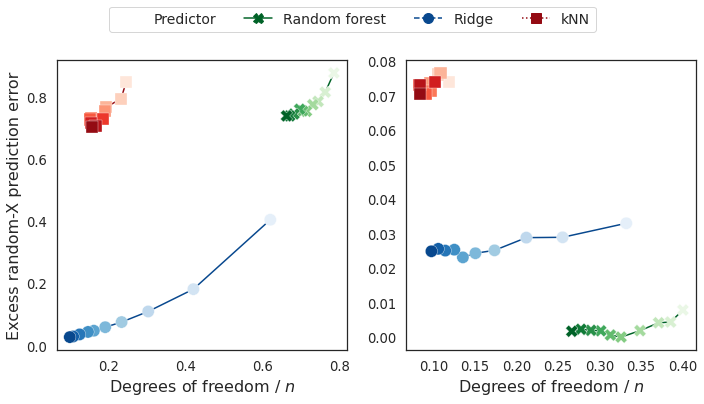

In [112]:
import matplotlib.lines as mlines

K = len(df['n'].unique())
palette = sns.color_palette("magma_r", K)
palette_list = [sns.color_palette("Greens", K),
                sns.color_palette("Blues", K),               
               sns.color_palette("Reds", K)]
marker_list = ['X', 'o', 's']
fig, axes = plt.subplots(1,2, figsize=(10,6))
for i, func in enumerate(['linear', 'clf']):
    for j, predictor in enumerate(['random_forest', 'ridge', 'kNN']):
        _df = df[(df['func']==func)&(df['predictor']==predictor)]
        sns.scatterplot(_df, x='dof_R', y='err_R',
                   hue='n', palette=palette_list[j], marker=marker_list[j], size=50, ax=axes[i])

        axes[i].collections[2*j].set_sizes([150])

        axes[i] = sns.lineplot(_df, x = "dof_R", y = "err_R", legend='full',
                     ls='-', color=palette_list[j][-1], zorder=0, ax=axes[i])
    
lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]

for i in range(2):
    axes[i].get_legend().remove()
    axes[i].set_xlabel('Degrees of freedom / $n$', fontsize=16)
for j in range(2):
    axes[j].set_box_aspect(1)
axes[0].set_ylabel('Excess random-X prediction error', fontsize=16)
axes[1].set_ylabel('', fontsize=16)

from matplotlib.lines import Line2D

def create_dummy_line(**kwds):
    return Line2D([], [], **kwds)    
lines = [
    create_dummy_line(**{'color': palette_list[0][-1], 'linestyle': '-', 'marker': 'X'}),
    create_dummy_line(**{'color': palette_list[1][-1], 'linestyle': '--', 'marker': 'o'}),
    create_dummy_line(**{'color': palette_list[2][-1], 'linestyle': ':', 'marker': 's'})
]
print(labels)
handles = np.r_[
                mlines.Line2D([], [], linestyle='None'),
                lines[0],
                lines[1],
                lines[2],
             ].tolist()
labels = np.r_[[
                'Predictor',
                'Random forest',
                'Ridge',
                'kNN',
               ]].tolist()


legend = fig.legend(handles=handles, labels=labels, 
                    loc=9, ncol=5, title=None, fontsize=14)
for item, label in zip(legend.legendHandles, legend.texts):
    if label.get_text() not in ['Random forest', 'Ridge', 'kNN']:
        item.set_color('black')
    item.set_markersize(10)



fig.tight_layout()
fig.subplots_adjust(top=0.99)
plt.savefig('result/sec6_pareto.pdf', dpi=300, facecolor='white', transparent=False)

## DoF comparison (Figure 7)

In [11]:
d = 100; sigma = .5; coef = 'random'; path_result = 'result/ex3/'
n = 200; sigma2 = sigma**2 if func=='linear' else 0.05

df_res_dict = {}
for func in ['linear', 'clf']:
    df_res_dict[func]  = {}

    for method in ['random_forest', 'ridge', 'kNN']:
        try:
            df_res = pd.read_csv('{}res_{}_{}_{}_{}_{}_{:.02f}.csv'.format(
                path_result, method, n, d, func, coef, sigma))
        except:
            continue
        if method=='random_forest':
            param = 'n_estimators'
        elif method in ['ridge', 'lasso']:
            param = 'lam'
        elif method=='kNN':
            param = 'k'

        df_res = df_res.groupby(['n','d','type','method',param]).mean()
        df_res = df_res.reset_index()
        sigma2 = df_res['sigma2'].mean()
        df_res['dof_F'] = (df_res['err_F'] - df_res['err_T']) / (2*sigma2) * n
        df_res['dof_R'] = comp_dof(df_res['err_R'], df_res['err_T'], sigma2) * n
        df_res['dof_R_shift'] = comp_dof(df_res['err_R_shift'], df_res['err_T'], sigma2) * n
        
        df_res_dict[func][method] = df_res

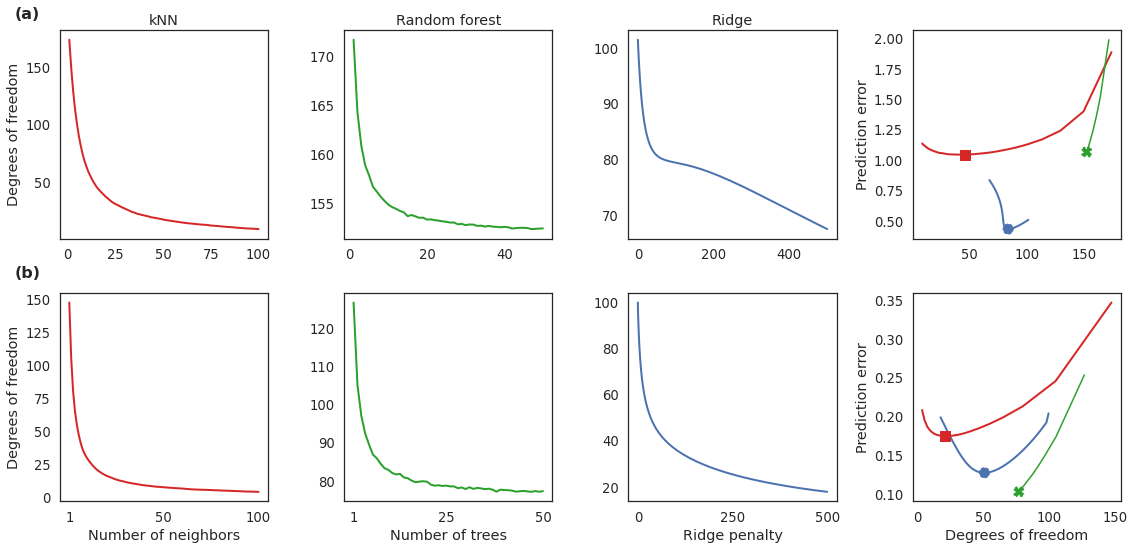

In [121]:
fig, axes = plt.subplots(2,4,figsize=(16,8))

for i, func in enumerate(['linear', 'clf']):
    df_res = df_res_dict[func]['kNN']
    df_res = df_res[df_res['type']=='emergent']
    sns.lineplot(data=df_res, x='k', y='dof_R', lw=2, legend='full',
                c=sns.color_palette("tab10")[3], ax=axes[i,0],
                )

    idx = (df_res['type']=='emergent')
    k = df_res[idx].iloc[df_res[idx]['dof_R'].argmin()]['k']
    sns.lineplot(data=df_res[(df_res['type']=='emergent')], x='dof_R', y='err_R', lw=2,
                c=sns.color_palette("tab10")[3], legend=False, ax=axes[i,-1])
    axes[i,-1].scatter(
        df_res[idx].iloc[df_res[idx]['err_R'].idxmin()]['dof_R'],
        df_res[idx].iloc[df_res[idx]['err_R'].idxmin()]['err_R'],
        lw=1, s=100, zorder=4,
        **{'color': sns.color_palette("tab10")[3],
        'linestyle': '-', 'marker': 's'}
    )


    df_res = df_res_dict[func]['random_forest']
    idx = (df_res['complexity']<=100)&(df_res['type']=='emergent')
    sns.lineplot(data=df_res[idx], x='complexity', y='dof_R', lw=2,
                color=sns.color_palette("tab10")[2], ax=axes[i,1],
                )

    sns.lineplot(data=df_res[idx&(df_res['type']=='emergent')], x='dof_R', y='err_R', #style='type',
                color=sns.color_palette("tab10")[2], legend=False, ax=axes[i,-1])
    axes[i,-1].scatter(
        df_res[idx].iloc[df_res[idx]['err_R'].idxmin()]['dof_R'],
        df_res[idx].iloc[df_res[idx]['err_R'].idxmin()]['err_R'],
        lw=1, s=100, zorder=4,
        **{'color': sns.color_palette("tab10")[2], 
        'linestyle': '--', 'marker': 'X'}
    )



    df_res = df_res_dict[func]['ridge']
    idx = (0.<df_res['n'])&(df_res['type']=='emergent')
    sns.lineplot(data=df_res[idx], x='lam', y='dof_R', lw=2, ax=axes[i,2], legend='full')
    sns.lineplot(data=df_res[idx], x='dof_R', y='err_R', lw=2,
                legend=False, ax=axes[i,-1])
    axes[i,-1].scatter(
        df_res[idx].iloc[df_res[idx]['err_R'].idxmin()]['dof_R'],
        df_res[idx].iloc[df_res[idx]['err_R'].idxmin()]['err_R'],
        lw=1, s=100, zorder=4,
        **{'linestyle': '--', 'marker': 'o'}
    )

    axes[i,0].set_ylabel('Degrees of freedom')
    axes[i,-1].set_ylabel('Prediction error')
    
x = [1,50,100]
axes[1,0].set_xticks(x, x)
x = [1,25,50]
axes[1,1].set_xticks(x, x)
axes[1,2].set_xticks([0, 250, 500])

axes[0,-1].set_xlabel('')
axes[1,-1].set_xlabel('Degrees of freedom')
xlabels = ['Number of neighbors', 'Number of trees', 'Ridge penalty']
for j,title in enumerate(['kNN','Random forest','Ridge']):
    axes[0,j].set_xlabel('')
    axes[1,j].set_xlabel(xlabels[j])

    if j>0:
        for i in range(2):
            axes[i,j].set_ylabel('')
            
    axes[0,j].set_title(title)
for i in range(2):
    for j in range(4):
        axes[i,j].set_box_aspect(1)
    
plt.figtext(0.02, 0.95, '(a)', weight='bold', fontsize=16)
plt.figtext(0.02, 0.5, '(b)', weight='bold', fontsize=16)

fig.tight_layout()

plt.savefig('result/sec6_dof_risk_{}_{:.01f}.pdf'.format(n,sigma), dpi=300, bbox_inches='tight')

## Covariate shift attribution (Figure 9)

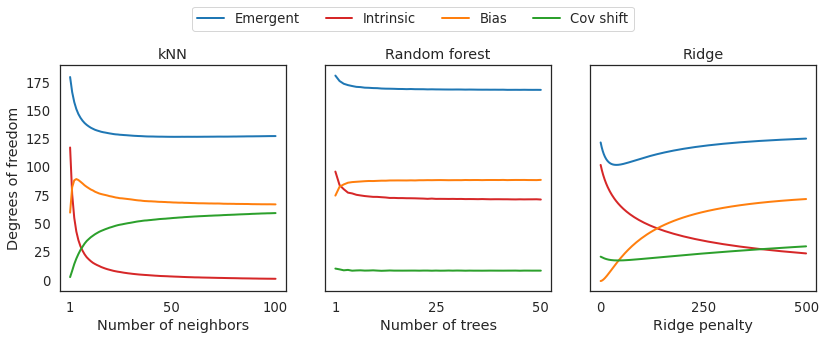

In [116]:
fig, axes = plt.subplots(1,3,figsize=(12,4.5),sharey=True)
func = 'linear'
_df_res = df_res_dict[func]['kNN']
df_res = _df_res[_df_res['type']=='emergent'].reset_index()
df_res['null'] = _df_res[_df_res['type']!='emergent']['dof_R'].values
df_res['null_shift'] = _df_res[_df_res['type']!='emergent']['dof_R_shift'].values
df_res['bias'] = 0.5 * (df_res['dof_R_shift'] - df_res['null_shift']) + 0.5 * (df_res['dof_R'] - df_res['null'])
df_res['cov_shift'] = 0.5 * (df_res['dof_R_shift'] - df_res['dof_R']) + 0.5 * (df_res['null_shift'] - df_res['null'])
sns.lineplot(data=df_res, x='k', y='dof_R_shift', lw=2,
             c=sns.color_palette("tab10")[0], ax=axes[0], label='df full')
sns.lineplot(data=df_res, x='k', y='null', lw=2,
             c=sns.color_palette("tab10")[3], ax=axes[0], label='df null')
sns.lineplot(data=df_res, x='k', y='bias', lw=2,
             c=sns.color_palette("tab10")[1], ax=axes[0], label='df bias')
sns.lineplot(data=df_res, x='k', y='cov_shift', lw=2,
             c=sns.color_palette("tab10")[2], ax=axes[0], label='df covariate shift')

_df_res = df_res_dict[func]['random_forest']
df_res = _df_res[(_df_res['type']=='emergent')].reset_index()
df_res['null'] = _df_res[_df_res['type']!='emergent']['dof_R'].values
df_res['null_shift'] = _df_res[_df_res['type']!='emergent']['dof_R_shift'].values
df_res['bias'] = 0.5 * (df_res['dof_R_shift'].values - df_res['null_shift']) + 0.5 * (df_res['dof_R'].values - df_res['null'])
df_res['cov_shift'] = 0.5 * (df_res['dof_R_shift'].values - df_res['dof_R'].values) + 0.5 * (df_res['null_shift'] - df_res['null'])
idx = (df_res['complexity']<=100)

sns.lineplot(data=df_res[idx], x='complexity', y='dof_R_shift', lw=2,
             color=sns.color_palette("tab10")[0], ax=axes[1], label='df full')
sns.lineplot(data=df_res[idx], x='complexity', y='null', lw=2,
             c=sns.color_palette("tab10")[3], ax=axes[1], label='df null')
sns.lineplot(data=df_res[idx], x='complexity', y='bias', lw=2,
             c=sns.color_palette("tab10")[1], ax=axes[1], label='df bias')
sns.lineplot(data=df_res[idx], x='complexity', y='cov_shift', lw=2,
             c=sns.color_palette("tab10")[2], ax=axes[1], label='df covariate shift')

_df_res = df_res_dict[func]['ridge']
df_res = _df_res[_df_res['type']=='emergent'].reset_index()
df_res['null'] = _df_res[_df_res['type']!='emergent']['dof_R'].values
df_res['null_shift'] = _df_res[_df_res['type']!='emergent']['dof_R_shift'].values
df_res['bias'] = 0.5 * (df_res['dof_R_shift'] - df_res['null_shift']) + 0.5 * (df_res['dof_R'] - df_res['null'])
df_res['cov_shift'] = 0.5 * (df_res['dof_R_shift'] - df_res['dof_R']) + 0.5 * (df_res['null_shift'] - df_res['null'])
idx = (0.<=df_res['n'])
sns.lineplot(data=df_res[idx], x='lam', y='dof_R_shift', lw=2, 
             c=sns.color_palette("tab10")[0], ax=axes[2], label='df full')
sns.lineplot(data=df_res[idx], x='lam', y='null', lw=2,
             c=sns.color_palette("tab10")[3], ax=axes[2], label='df null')
sns.lineplot(data=df_res[idx], x='lam', y='bias', lw=2,
             c=sns.color_palette("tab10")[1], ax=axes[2], label='df bias')
sns.lineplot(data=df_res[idx], x='lam', y='cov_shift', lw=2,
             c=sns.color_palette("tab10")[2], ax=axes[2], label='df covariate shift')


x = [1,50,100]
axes[0].set_xticks(x, x)
x = [1,25,50]
axes[1].set_xticks(x, x)
axes[2].set_xticks([0, 250, 500])

    
axes[0].set_ylabel('Degrees of freedom')

xlabels = ['Number of neighbors', 'Number of trees', 'Ridge penalty']
for j,title in enumerate(['kNN','Random forest','Ridge']):
    axes[j].set_xlabel(xlabels[j])
    
    if j>0:
        axes[j].set_ylabel('')
            
    axes[j].set_title(title)


lines_labels = [ax.get_legend_handles_labels() for ax in axes[:1]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
labels = ['Emergent', 'Intrinsic', 'Bias', 'Cov shift']
for j in range(3):
    axes[j].get_legend().remove()
for j in range(3):
    axes[j].set_box_aspect(1)
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=5)

legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.8)
plt.savefig('result/sec6_attr_{}_{}_{:.01f}.pdf'.format(func,n,sigma), dpi=300, facecolor='white', transparent=False, bbox_inches='tight')

## Barplot (Figure 10)

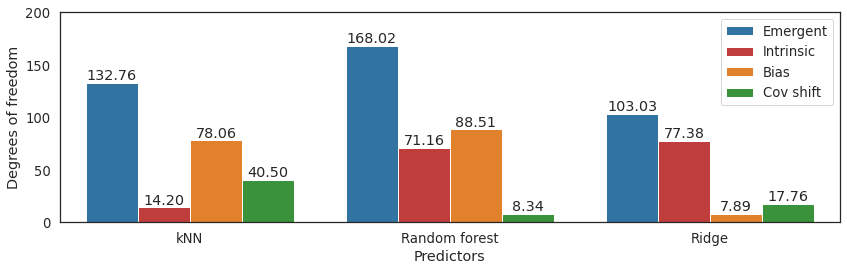

In [117]:
df_bar = pd.DataFrame()
res = []
params = ['k','complexity','lam']
for i,pred in enumerate(['kNN', 'random_forest', 'ridge']):
    _df_res = df_res_dict[func][pred]
    df_res = _df_res[_df_res['type']=='emergent'].reset_index()
    df_res['null'] = _df_res[_df_res['type']!='emergent']['dof_R'].values
    df_res['null_shift'] = _df_res[_df_res['type']!='emergent']['dof_R_shift'].values
    df_res['bias'] = 0.5 * (df_res['dof_R_shift'] - df_res['null_shift']) + 0.5 * (df_res['dof_R'] - df_res['null'])
    df_res['cov_shift'] = 0.5 * (df_res['dof_R_shift'] - df_res['dof_R']) + 0.5 * (df_res['null_shift'] - df_res['null'])

    p = df_res.iloc[df_res['err_R_shift'].idxmin()][params[i]]
    res.append(np.append([pred, p], df_res[df_res[params[i]]==p][['err_R_shift', 'dof_R_shift','null','bias','cov_shift']].values))
    
df_bar = pd.DataFrame(res, columns=['predictor', 'p', 'err', 'value-full', 'value-null', 'value-nzbias', 'value-nzcovariate shift'])
df_bar['id'] = df_bar.index

df_bar = pd.wide_to_long(df_bar, stubnames='value', sep='-', suffix='.*', i='predictor', j='df')
df_bar = df_bar.reset_index()
df_bar['value'] = df_bar['value'].astype(float)

sns.set_theme(style="white",  font_scale=1.2)
fig, ax = plt.subplots(1,1,figsize=(12,4))

sns.barplot(data=df_bar, x='id', y='value', hue='df', 
            hue_order=['full', 'null', 'nzbias', 'nzcovariate shift'], 
            palette= np.r_[[sns.color_palette("tab10")[0], sns.color_palette("tab10")[3]], sns.color_palette("tab10")[1:3]].tolist(),
            ax=ax)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')
ax.set_ylim([0,200])

lines_labels = [ax.get_legend_handles_labels() for ax in [ax]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
labels = ['Emergent', 'Intrinsic', 'Bias', 'Cov shift']

ax.get_legend().remove()
legend = ax.legend(handles=handles, labels=labels)
ax.set_xlabel('Predictors')
ax.set_ylabel('Degrees of freedom')
ax.set_xticklabels(['kNN', 'Random forest', 'Ridge'])
fig.tight_layout()

plt.savefig('result/sec6_barplot_{}_{}_{:.01f}.pdf'.format(func,n,sigma), dpi=300, facecolor='white', transparent=False, bbox_inches='tight')